In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
from matplotlib.colors import LogNorm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import healpy as hp
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import interpolate

Populating the interactive namespace from numpy and matplotlib


In [18]:
z = 0.07 #.193
ra_c = 30.0
dec_c = 0.0
nside = 2048
h = 0.7
npix = 3542
planck_fwhm = 10.0
spt_fwhm = 2.0
cd = cosmo.comoving_distance(z)

pix_ang = 8.382053568392354/(cd.value*1000/(1+z))
print('each pixel is', pix_ang/np.pi*180*60*60, 'arcsec')
print('full image is', pix_ang/np.pi*180*npix, 'deg on a side')

each pixel is 6.270939301544192 arcsec
full image is 6.169907501685979 deg on a side


In [14]:
cat = np.genfromtxt('/Users/chihwaychang/Work/300SimSZ/GadgetX_center_positions.dat')
M200c = cat[:,4]/1000/h
R200c = cat[:,8]/h

In [15]:
# def M200c_to_R200c(mass, z, cosmo):
#     rho_c_z = cosmo.critical_density(z)
#     mass_units = mass*u.Msun
#     R200c = ((mass_units/(200.*4.*np.pi*rho_c_z/3.))**(1./3.)).to('Mpc') 
#     return R200c.value

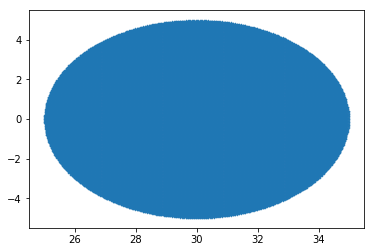

In [16]:
# define grid to work on
healpix_grid = np.arange(hp.nside2npix(nside))
theta, phi = hp.pix2ang(nside, healpix_grid)
ra = phi/np.pi*180
dec = 90.0 - (theta/np.pi*180)

c1 = SkyCoord(ra_c*u.degree, dec_c*u.degree, frame='icrs')
c2 = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
sep = c1.separation(c2)
mask_area = (sep.degree<5)
mplot.scatter(ra[mask_area], dec[mask_area], marker='.', s=1)

peak is in pixel [3.39946047] [3.30885466]
number of unique pixels 47119
0
10000
20000
30000
40000
Sigma is 4.246606 arcmin (0.001235 rad) 
-> fwhm is 9.999993 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.849321 arcmin (0.000247 rad) 
-> fwhm is 1.999999 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<Figure size 432x288 with 0 Axes>

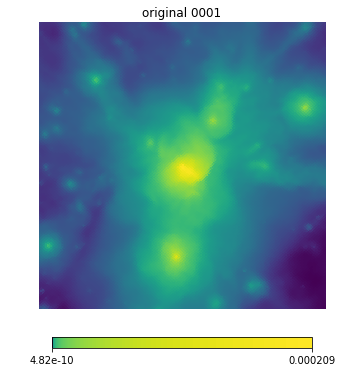

<Figure size 432x288 with 0 Axes>

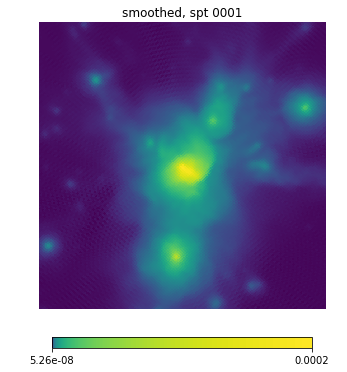

<Figure size 432x288 with 0 Axes>

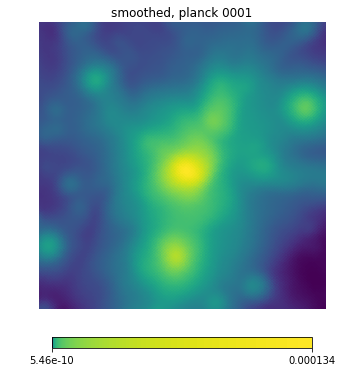

peak is in pixel [3.22696094] [3.03877963]
number of unique pixels 46977
0
10000
20000
30000
40000
Sigma is 4.246606 arcmin (0.001235 rad) 
-> fwhm is 9.999993 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.849321 arcmin (0.000247 rad) 
-> fwhm is 1.999999 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<Figure size 432x288 with 0 Axes>

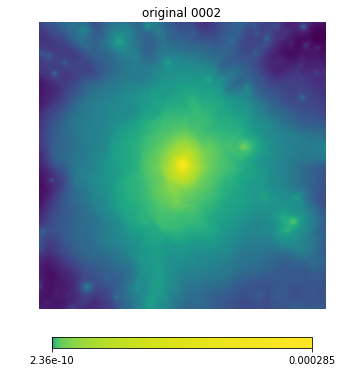

<Figure size 432x288 with 0 Axes>

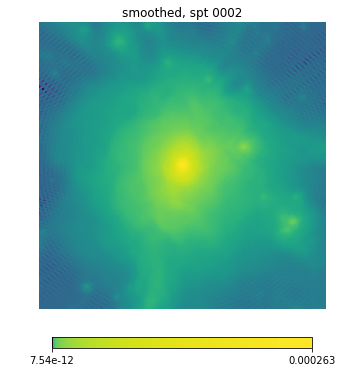

<Figure size 432x288 with 0 Axes>

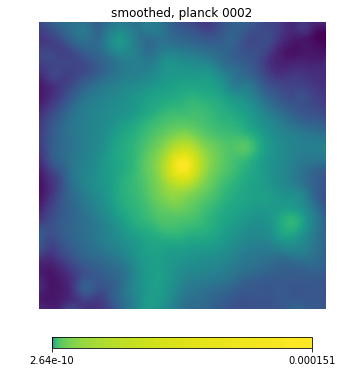

peak is in pixel [2.77044703] [3.08408254]
number of unique pixels 47002
0
10000


In [ ]:
for i in range(10):
    
    ii = '000'+str(i+1)
    if i>=9 and i<99:
        ii = '00'+str(i+1)
    
    # read in file
    cluster = pf.open('/Users/chihwaychang/Work/300SimSZ/NewMDCLUSTER_'+str(ii)+'/snap_120-TT-z-cl-'+str(int(ii))+'-WV.fits')
    cluster_sim = cluster[0].data
    
    # center image on RA/DEC grid
    image_size = int(npix)
    nx, ny = (image_size, image_size)
    x = np.linspace(0, pix_ang/np.pi*180*image_size, nx)
    y = np.linspace(0, pix_ang/np.pi*180*image_size, ny)
    xv, yv = np.meshgrid(x, y)

    peak_pix = (cluster_sim == np.max(cluster_sim))
    print('peak is in pixel', xv[peak_pix], yv[peak_pix])

    xv = xv - xv[peak_pix] + 30.0
    yv = yv - yv[peak_pix] + 0.0
    xv = 30 + (xv-30.)*np.cos(yv/180.0*np.pi)

    # put on healpix grid
    joint_map = np.zeros(hp.nside2npix(nside))
    theta = (90.-yv.flatten())/180*np.pi
    phi = xv.flatten()/180*np.pi
    pix = hp.ang2pix(nside, theta, phi)
    unique_pix = np.unique(pix, return_counts=True)[0]
    map_flat = cluster_sim.flatten()
    
    print('number of unique pixels', len(unique_pix))
    for j in range(len(unique_pix)):
        if j%10000==0: print(j)
        mask_pixi = (pix==unique_pix[j])
        joint_map[unique_pix[j]] = np.mean(map_flat[mask_pixi])

    joint_map_smooth_planck = hp.smoothing(joint_map,fwhm=planck_fwhm*0.000290888, lmax=2*nside)
    joint_map_smooth_spt = hp.smoothing(joint_map,fwhm=spt_fwhm*0.000290888, lmax=2*nside)
    
    mplot.figure()
    hp.cartview(joint_map-np.min(joint_map)+1e-13, lonra=[28,32], latra=[-2,2], norm=LogNorm(), title='original '+str(ii))
    mplot.figure()
    hp.cartview(joint_map_smooth_spt-np.min(joint_map_smooth_spt)+1e-13, lonra=[28,32], latra=[-2,2], norm=LogNorm(), title='smoothed, spt '+str(ii))
    mplot.figure()
    hp.cartview(joint_map_smooth_planck-np.min(joint_map_smooth_planck)+1e-13, lonra=[28,32], latra=[-2,2], norm=LogNorm(), title='smoothed, planck '+str(ii))
    mplot.show()
    
    small_mask = healpix_grid[joint_map!=0]
    small_joint_map = joint_map[joint_map!=0]
    small_joint_map_smooth_spt = joint_map_smooth_spt[joint_map!=0]
    small_joint_map_smooth_planck = joint_map_smooth_planck[joint_map!=0]
    
    np.savez('smoothed_cluster_map_'+str(ii)+'.npz', hpix=small_mask, original=small_joint_map, 
             spt=small_joint_map_smooth_spt, planck=small_joint_map_smooth_planck)